<a href="https://colab.research.google.com/github/Moncef-Belmadoui/TSA_Project/blob/main/TSA_coal_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Analysis of Coal Power Consumption in Texas: Trends, Modeling, and Forecasting**
---
Coal remains a significant energy source in Texas, despite the rise of renewable energy. Analyzing coal consumption over time can help policymakers, energy providers, and environmentalists understand demand patterns, seasonal trends, and potential shifts toward alternative energy sources.

---

# **About my data**

This dataset captures the coal consumption for electric power generation in Texas on a quarterly basis. The dataset contains two columns: Quarter and Total Consumption.

  - **Source**: [Github Repo](https://github.com/rishabh89007/Time_Series_Datasets)

  - **What it is**: The dataset consists of total coal consumption (in short tons) for electric power in Texas, recorded quarterly. The data spans from 2001 to 2020

  - **Form**: CSV

- **Time Recorded**: Quarterly  
- **Shape**: 80 rows, 2 columns  

# **Data Exploration**

In this section, we will focus on exploring our time series to gain a deeper understanding of its patterns and characteristics

In [ ]:
# install packages
install.packages("zoo")
install.packages("tseries")
install.packages("forecast")
install.packages("ggplot2")
install.packages("DescTools")
install.packages("TSA")
library(TSA)
library(DescTools)
library(forecast)
library(tseries)
library(ggplot2)
library(zoo)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘TSA’


The following objects are masked from ‘package:stats’:

    acf, arima


The following object is masked from ‘package:utils’:

    tar


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method       from
  fitted.Arima TSA 
  plot.Arima   TSA 


Attaching package: ‘forecast’


The following object is masked from ‘package:DescTools’:

    BoxCox



Attaching package: ‘zoo

In [ ]:
#load data
url <- "https://raw.githubusercontent.com/Moncef-Belmadoui/TSA_Project/refs/heads/main/Coal%20Power.csv"
coal_ts <- read.csv(url , check.names = FALSE)
head(coal_ts)

,,Total consumption : Texas : electric power (total) : quarterly (short tons)
,<chr>,<int>
1,2001 Q1,22164839
2,2001 Q2,22952510
3,2001 Q3,25962808
4,2001 Q4,21357650
5,2002 Q1,21917084
6,2002 Q2,23929655


## This code renames columns for clarity and converts quarterly date strings (e.g., "2001 Q1") into proper date format (e.g., "2001-01-01"), ensuring compatibility for time series analysis.

In [ ]:
#rename cols
names(coal_ts) <- c("date", "coal_consumption")

map_quarter_to_date <- function(qtr_string) {
  qtr_string <- trimws(qtr_string)
  parts <- strsplit(qtr_string, " ")
  year    <- sapply(parts, `[`, 1)  # first part is the year
  quarter <- sapply(parts, `[`, 2)  # second part is the quarter
  # Map quarters to the starting month:
  month <- ifelse(quarter == "Q1", "01",
           ifelse(quarter == "Q2", "04",
           ifelse(quarter == "Q3", "07",
           ifelse(quarter == "Q4", "10", NA))))

  # Construct a date string for the first day of the quarter
  date_str <- paste(year, month, "01", sep = "-")
  as.Date(date_str)
}
coal_ts$date <- map_quarter_to_date(coal_ts$date)
str(coal_ts)
head(coal_ts)

'data.frame':	80 obs. of  2 variables:
 $ date            : Date, format: "2001-01-01" "2001-04-01" ...
 $ coal_consumption: int  22164839 22952510 25962808 21357650 21917084 23929655 26277274 23548673 23284033 24767874 ...


,date,coal_consumption
,<date>,<int>
1,2001-01-01,22164839
2,2001-04-01,22952510
3,2001-07-01,25962808
4,2001-10-01,21357650
5,2002-01-01,21917084
6,2002-04-01,23929655


## **Helpful plots of the data**

***Time serie plot***

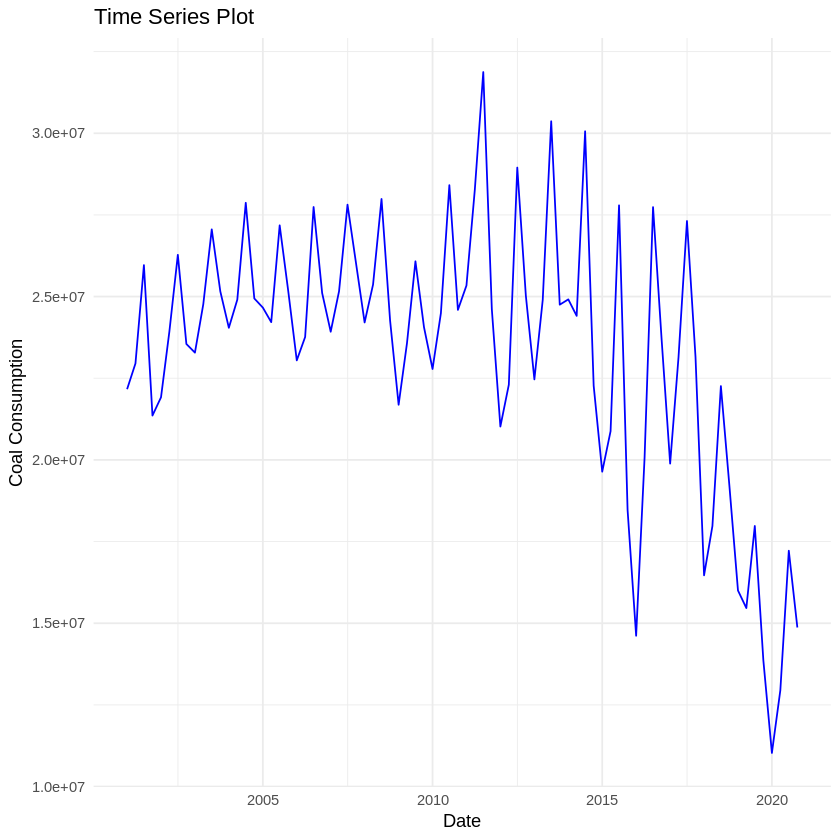

In [ ]:
ggplot(coal_ts, aes(x = date, y = coal_consumption)) +
  geom_line(color = "blue") +
  labs(title = "Time Series Plot", x = "Date", y = "Coal Consumption") +
  theme_minimal()

***Histogram***

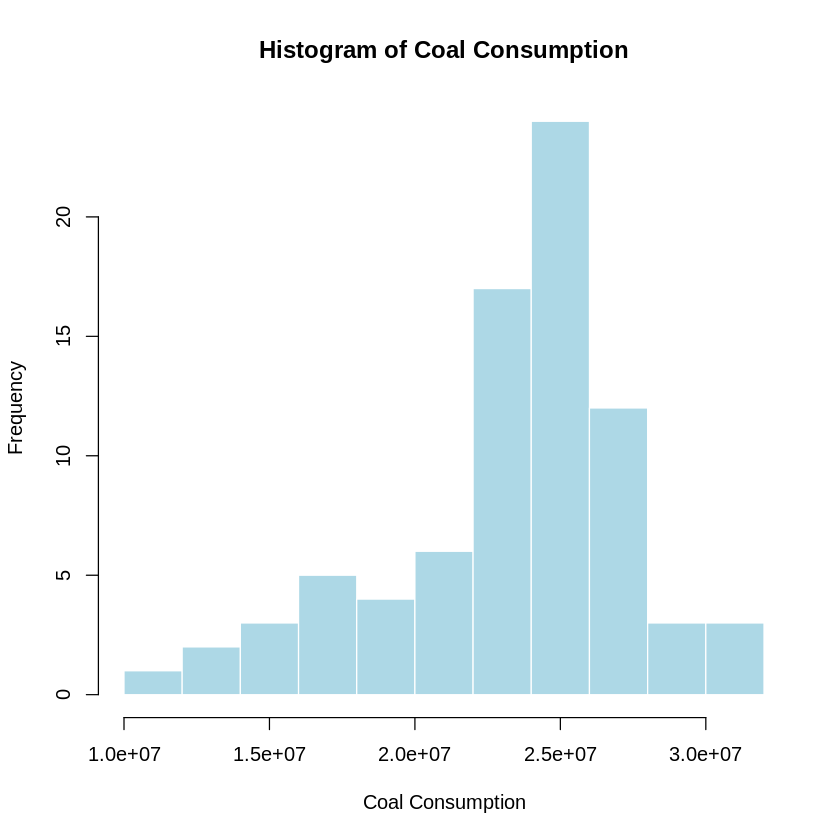

In [ ]:
hist(coal_ts$coal_consumption, main = "Histogram of Coal Consumption", xlab = "Coal Consumption", col = "lightblue", border = "white")

***Q-Q Plot***

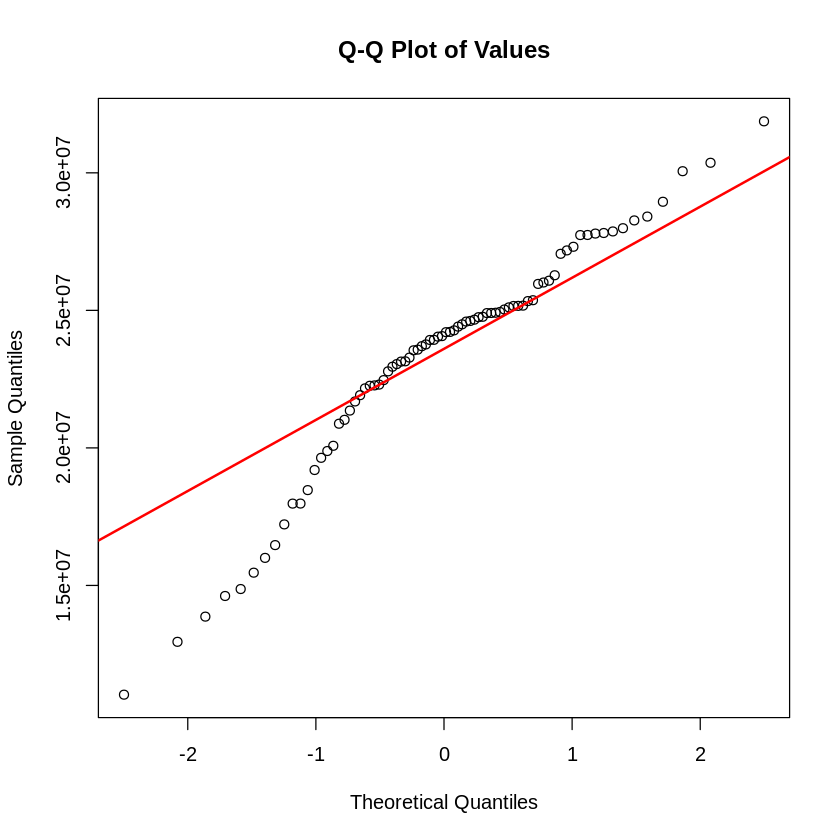

In [ ]:
qqnorm(coal_ts$coal_consumption, main = "Q-Q Plot of Values")
qqline(coal_ts$coal_consumption, col = "red", lwd = 2)

**ACF**

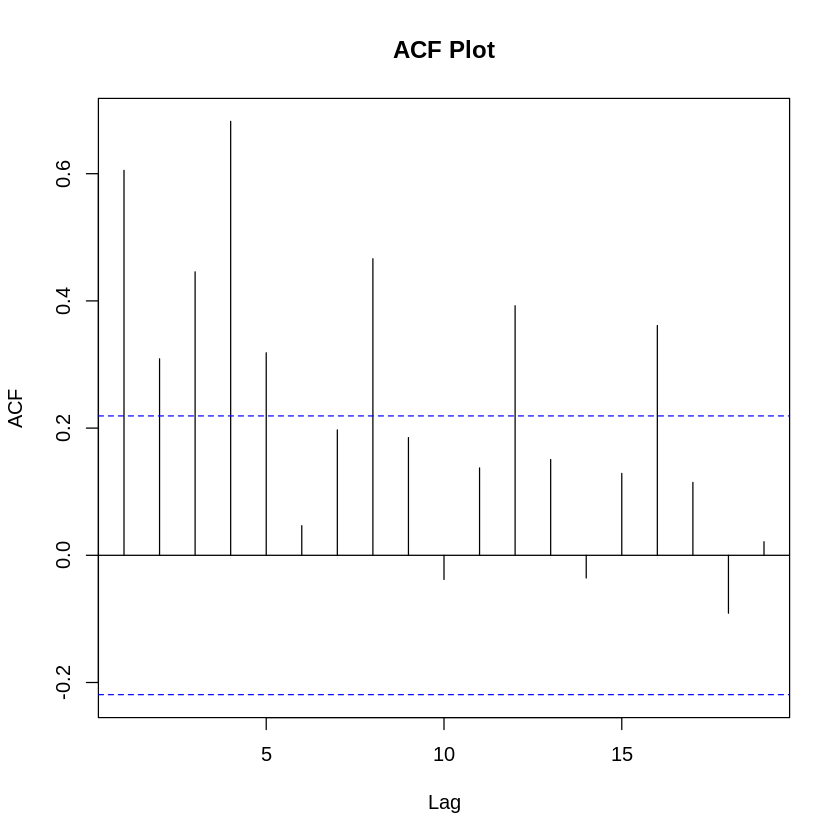

In [ ]:
acf(coal_ts$coal_consumption, main = "ACF Plot")

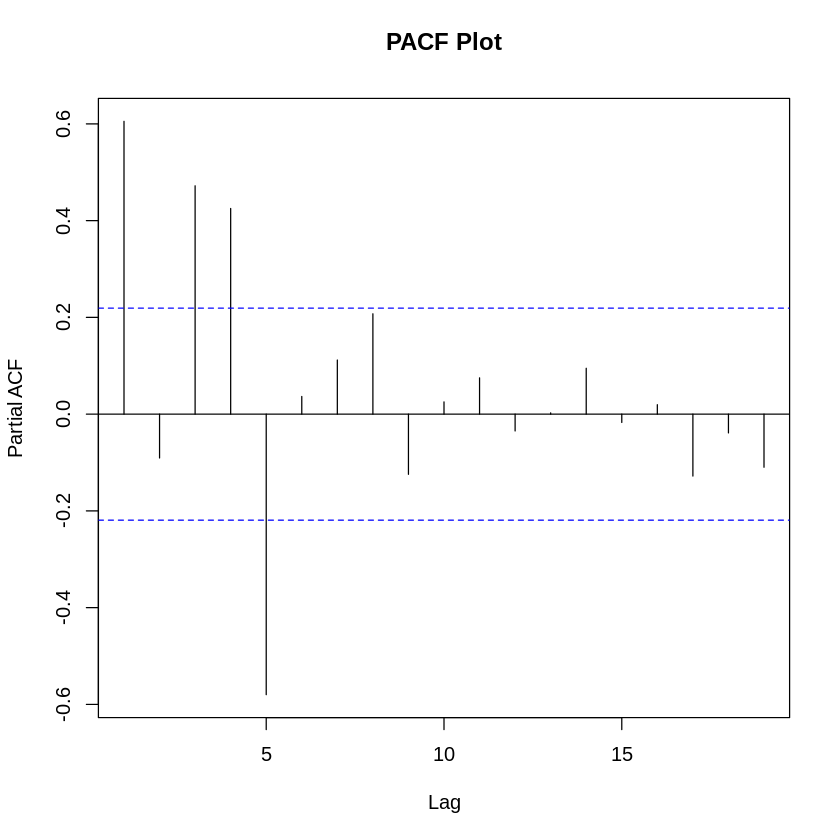

In [ ]:
pacf(coal_ts$coal_consumption, main = "PACF Plot")

# **Comments on the plots**

By analyzing the plots, we observe the following:

**Trend** : The time series plot reveals a clear downward trend, particularly noticeable from around 2015.

**Variance** : The increasing spread in values over time in the time series plot suggests heteroscedasticity (non-constant variance).

**Non-Stationarity** : The presence of a trend and changing variance implies that the series is non-stationary, as its mean and variance changes over time.

To address these issues, we should apply variance stabilization method and differencing to make the series stationary before modeling.



## **Data Spliting : Train and Test**
Before proceeding, we need to **split the data** into training and testing  sets to evaluate forecasting performance effectively.
   - **Training Set**: The part that we will use for training our model - 90%
   - **Test Set**: The part that we will use for evaluating and testing our model - 10%
   

In [ ]:
# spliting the data
train_size <- floor(nrow(coal_ts) * 0.9)

train_ts <- coal_ts[1:train_size, ]
test_ts <- coal_ts[(train_size + 1):nrow(coal_ts), ]

cat("Training set size:", nrow(train_ts), "\n")
cat("Testing set size:", nrow(test_ts), "\n")

Training set size: 72 
Testing set size: 8 


#**Exploring Candidate Models**
In this section, we start the process of searching for candidate models to analyze our time series data effectively. We will explore various ARIMA models, by exploring these candidate models, we aim to identify the most suitable approach for modeling our data.

---

##**Log Transformation for Variance Stabilization**
Before proceeding with modeling, it's essential to stabilize the variance of our time series data. One common technique for achieving this is the Log transformation. By applying the Log transformation, we aim to make the variance of the data more consistent.

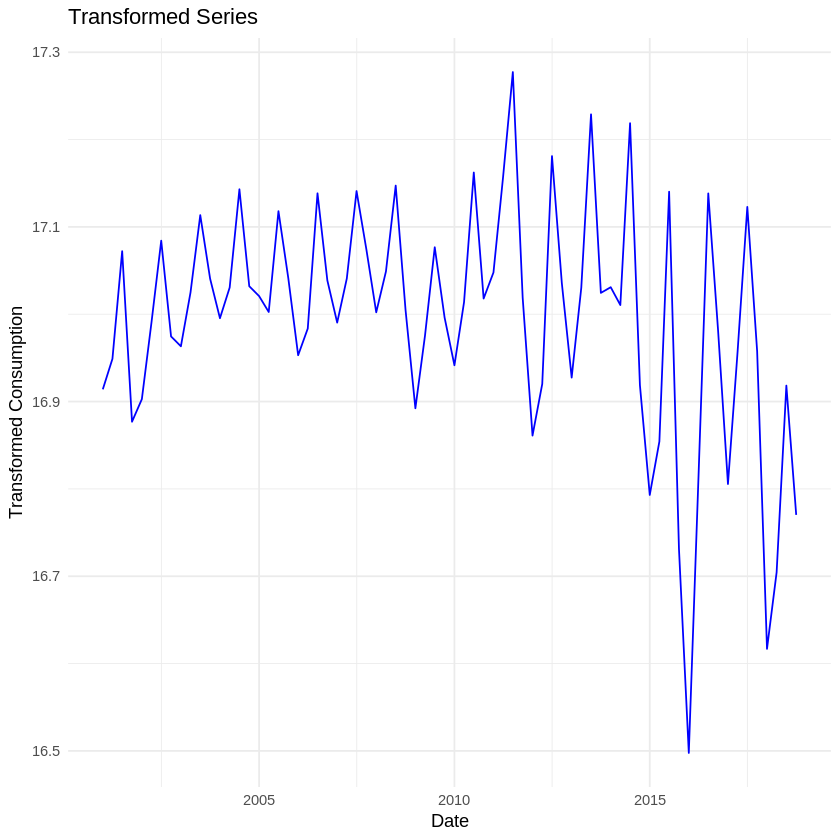

In [ ]:
#apply log transformation to the training set
train_ts$log <- log(train_ts$coal_consumption)
test_ts$log <- log(test_ts$coal_consumption)

ggplot(train_ts, aes(x = date, y = log)) +
  geom_line(color = "blue") +
  labs(title = "Transformed Series", x = "Date", y = "Transformed Consumption") +
  theme_minimal()



#**First Diffrence for Trend Removal**
To remove the trend from our time series data, we will apply the first difference transformation. We aim to eliminate the trend present in the data and try to make it stationary and more amenable to modeling techniques that assume stationarity.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


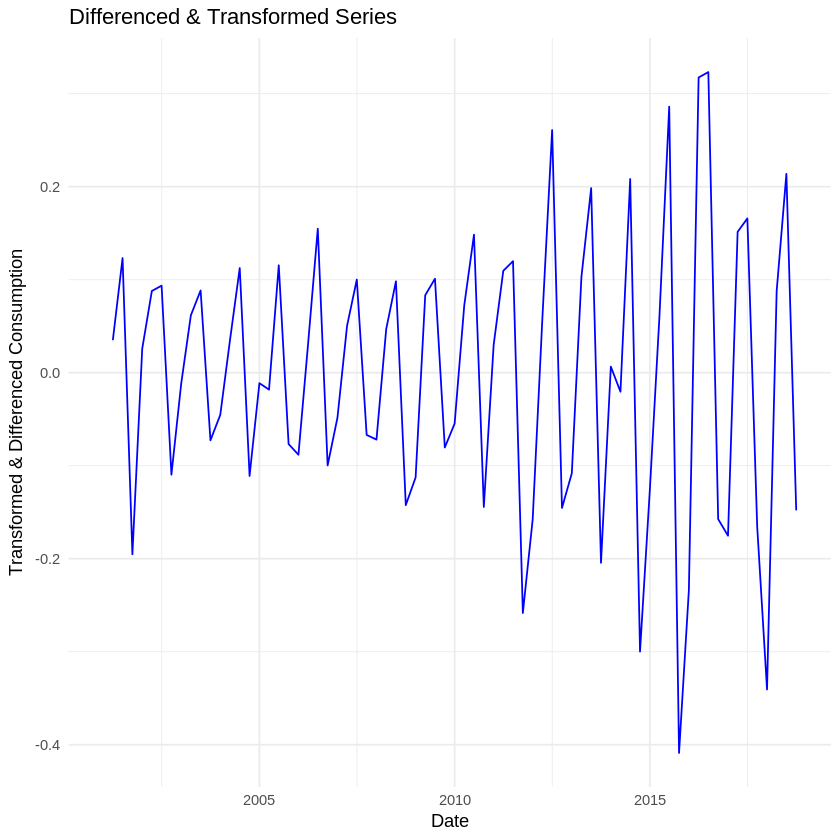

In [ ]:
# Apply first-order differencing to remove trend
train_ts$diff <- c(NA,diff(train_ts$log, differences = 1))
test_ts$diff <- c(NA,diff(test_ts$log, differences = 1))

train_ts_diff = train_ts[-1,]
test_ts_diff = test_ts[-1,]

# Plot the differenced series
ggplot(train_ts, aes(x = date, y = diff)) +
  geom_line(color = "blue") +
  labs(title = "Differenced & Transformed Series", x = "Date", y = "Transformed & Differenced Consumption") +
  theme_minimal()



Looking at the plot of the resulting data after applying the first difference transformation, we can see that the linear trend has been removed effectively. This means the data now is stationary, without a clear upward or downward trend. Overall, the plot confirms that the first difference transformation has achieved its goal of detrending the data.

##**Augmented Dickey-Fuller test**
In order to assess the stationarity of our time series data after applying the first difference transformation, we will conduct the Augmented Dickey-Fuller (ADF) test.

In [ ]:
# Perform the Augmented Dickey-Fuller test
adf_test_result <- adf.test(train_ts_diff$diff)
print(adf_test_result)


	Augmented Dickey-Fuller Test

data:  train_ts_diff$diff
Dickey-Fuller = -4.0385, Lag order = 4, p-value = 0.01303
alternative hypothesis: stationary



The Augmented Dickey-Fuller (ADF) test results indicate a significant p-value of 0.01303 which is less than 0.05. These results provide compelling evidence that the first difference transformation has successfully rendered the data stationary, validating its suitability for further time series analysis and modeling.


#**Distribution of Data after First Difference**

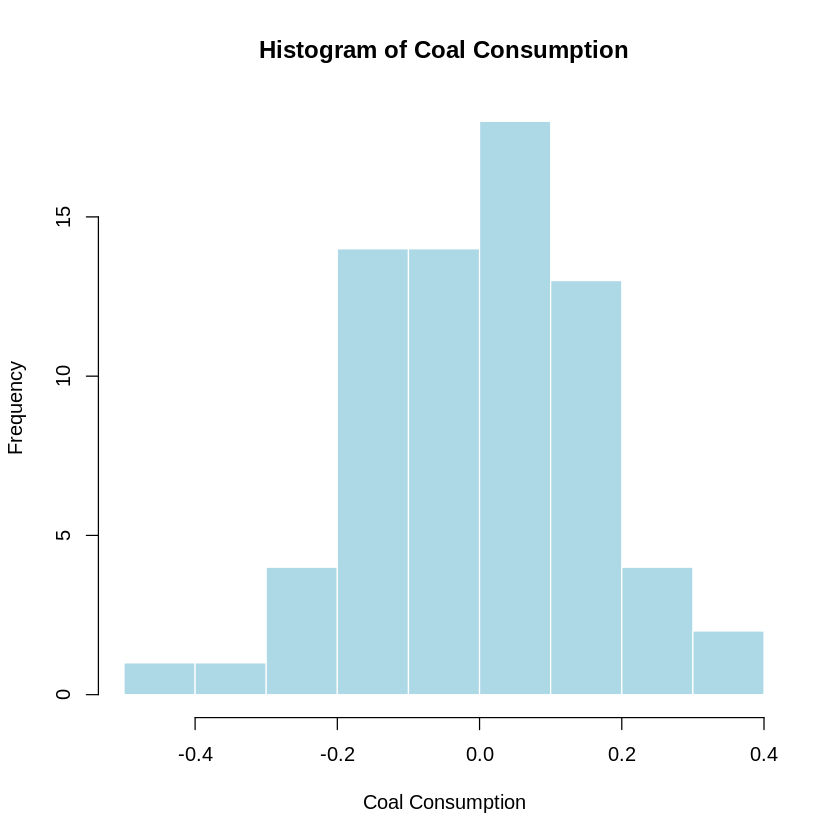

In [ ]:
hist(train_ts_diff$diff, main = "Histogram of Coal Consumption", xlab = "Coal Consumption", col = "lightblue", border = "white")

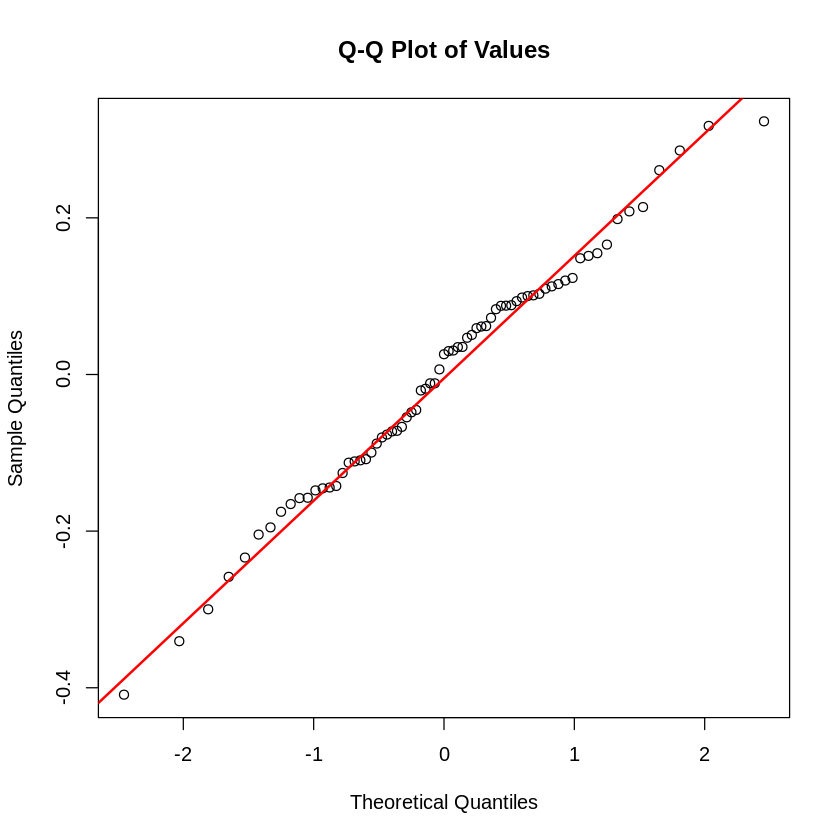

In [ ]:
qqnorm(train_ts_diff$diff, main = "Q-Q Plot of Values")
qqline(train_ts_diff$diff, col = "red", lwd = 2)

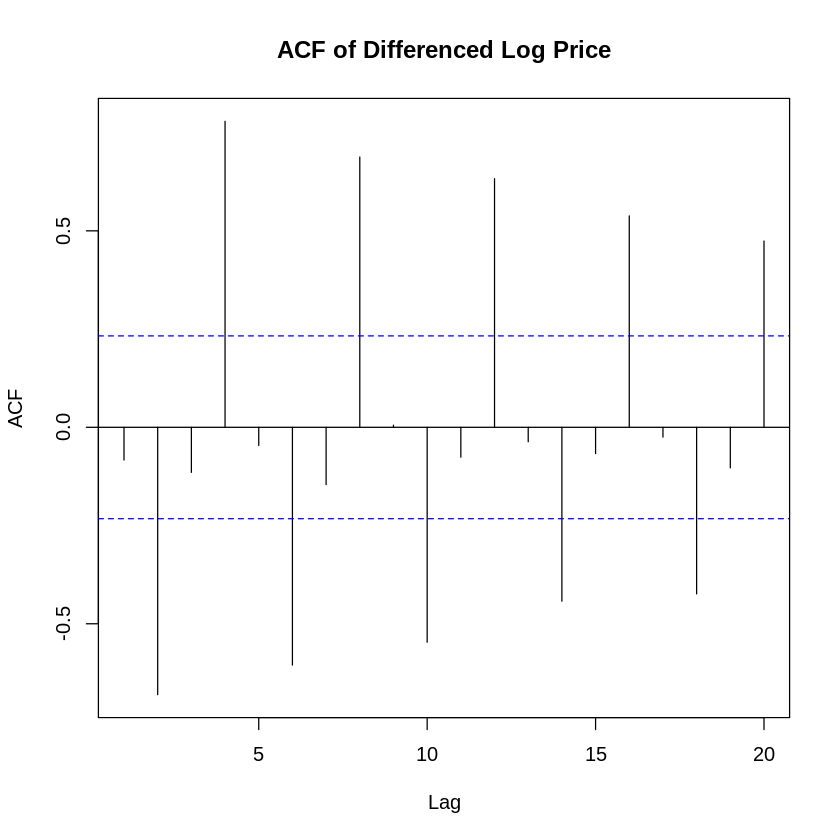

In [ ]:
acf(train_ts_diff$diff, main = "ACF of Differenced Log Price",lag.max = 20)

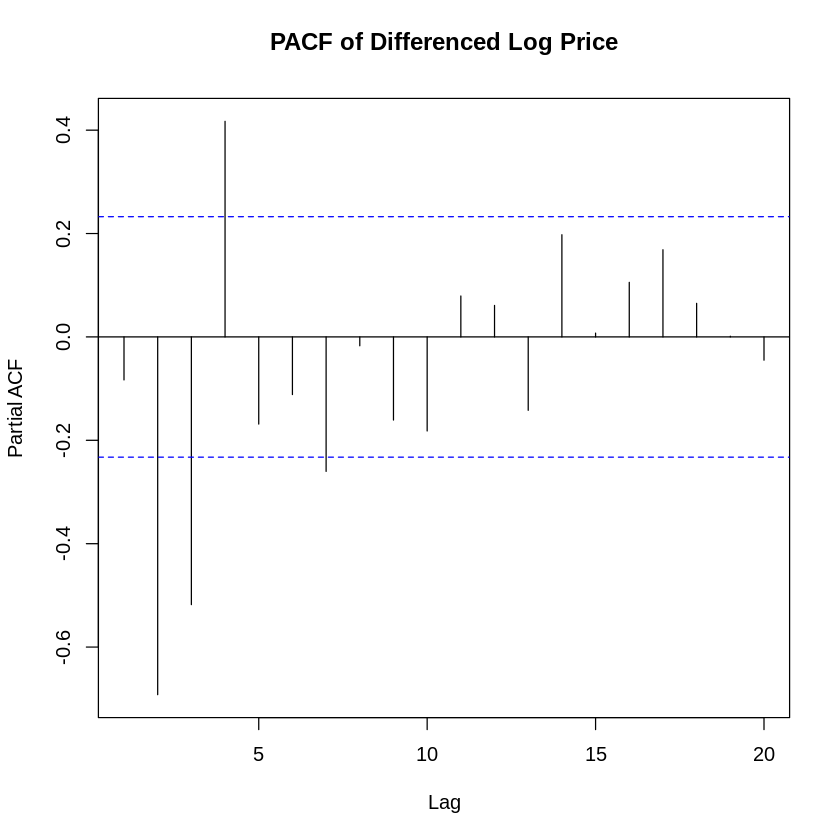

In [ ]:
pacf(train_ts_diff$diff, main = "PACF of Differenced Log Price" , lag.max = 20)

##**Shapiro-Wilk test & Runs test**

In [ ]:
shapiro.test(train_ts_diff$diff)


	Shapiro-Wilk normality test

data:  train_ts_diff$diff
W = 0.98776, p-value = 0.7227


In [ ]:
RunsTest(train_ts_diff$diff)


	Runs Test for Randomness

data:  train_ts_diff$diff
z = 0, runs = 36, m = 36, n = 35, p-value = 1
alternative hypothesis: true number of runs is not equal the expected number
sample estimates:
 median(x) 
0.02585643 


##**Comments on the Test Results**

  - **Shapiro-Wilk Normality Test**

    The high p-value (0.7227) suggests that we fail to reject the null hypothesis, meaning the differenced data follows a normal distribution.

  - **Runs Test**

  The high p-value (1.0) indicates that the null hypothesis (that the data points occur in a random sequence) cannot be rejected. This means the differenced series does not exhibit patterns or autocorrelation, suggesting that differencing successfully removed trends and made the series more stationary.


# **Exploring Candidates Models Based on ACF and PACF Analysis**

After analyzing the (ACF) and (PACF) of the first difference data, we can get insights into the potential orders of (AR) and (MA) components for the ARIMA model.

- **Partial Autocorrelation Function (PACF) Plot**

     - The PACF helps identify the AR (Auto-Regressive) order (p).

     - We look for the last significant lag before the PACF cuts off (i.e., becomes insignificant beyond the confidence bands).

     - From the PACF plot, we see strong spikes at lags 2, 3, and 4, with possible significance at lag 5.
     - This suggests that p = 4 is a reasonable choice, with alternatives p = 3 or 5.

- **Autocorrelation Function (ACF) Plot**

     - The ACF helps determine the MA (Moving Average) order (q).

     - We look for the last significant lag before the ACF cuts off.

     - The ACF shows significant spikes at lag 2, indicating that q = 1, 2, or 3 could be suitable choices.


---

#**Candidate Models**
Based on the above observations, the following ARIMA(p, d, q) models could be tested:

- **ARIMA(3,1,1)**
- **ARIMA(4,1,1)**
- **ARIMA(4,1,2)**


We will begin by fitting these models to the time series data. After fitting the models, we will conduct an analysis of the residuals to assess its validity.

---

#**ARIMA(3,1,1)** :

In [ ]:
arima_model_311 = Arima(train_ts_diff$diff, order = c(3,1,1))

summary(arima_model_311)

Series: train_ts_diff$diff 
ARIMA(3,1,1) 

Coefficients:
          ar1      ar2      ar3     ma1
      -0.8940  -0.9275  -0.8905  0.0405
s.e.   0.0634   0.0451   0.0541  0.1490

sigma^2 = 0.007028:  log likelihood = 73.39
AIC=-136.79   AICc=-135.85   BIC=-125.55

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.002290146 0.08082647 0.06144777 59.74244 99.91408 0.3614221
                     ACF1
Training set -0.007133004


	Ljung-Box test

data:  Residuals from ARIMA(3,1,1)
Q* = 15.14, df = 6, p-value = 0.01919

Model df: 4.   Total lags used: 10



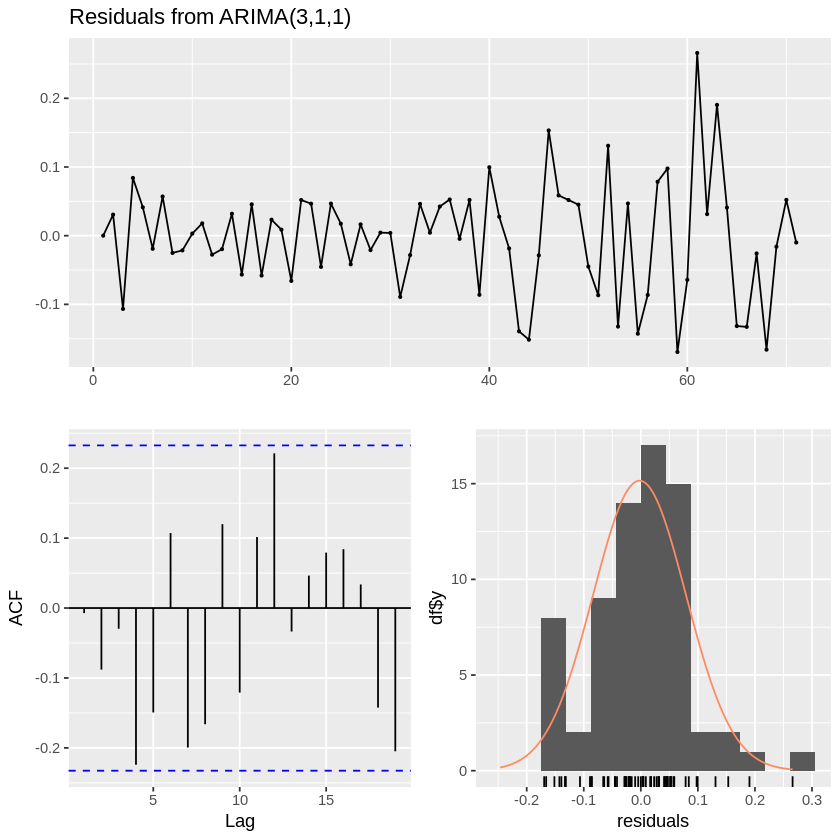

In [ ]:
# Diagnostic checks
checkresiduals(arima_model_311)

In [ ]:
residuals_311 <- residuals(arima_model_311)
#Check for normality
shapiro.test(residuals_311)


	Shapiro-Wilk normality test

data:  residuals_311
W = 0.96437, p-value = 0.04143


In [ ]:
#Check for independence
RunsTest(residuals_311)


	Runs Test for Randomness

data:  residuals_311
z = 0.95816, runs = 41, m = 36, n = 35, p-value = 0.338
alternative hypothesis: true number of runs is not equal the expected number
sample estimates:
 median(x) 
0.00399093 


##**Conclusion on ARIMA(3,1,1) Validity**
The residual analysis of the ARIMA(3,1,1) model reveals
- **Normality** : The Shapiro-Wilk test got a p-value of 0.04143 < 0.05, indicating that the residuals do not follow a normal distribution.
- **Independence** : the runs test for randomness yields a p-value of 0.338, which implies that they exhibit randomness

Based on these results , the residuals are not normal white noise, hence, the summary of the model is ***not valid***

#**ARIMA(4,1,1)**:

In [ ]:
arima_model_411 = Arima(train_ts_diff$diff, order = c(4,1,1))

summary(arima_model_411)

Series: train_ts_diff$diff 
ARIMA(4,1,1) 

Coefficients:
          ar1      ar2      ar3     ar4      ma1
      -0.1671  -0.3088  -0.2258  0.6009  -1.0000
s.e.   0.1025   0.0980   0.0992  0.1035   0.1035

sigma^2 = 0.006103:  log likelihood = 77.41
AIC=-142.82   AICc=-141.49   BIC=-129.33

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.006836842 0.07475097 0.05674057 51.37923 87.43997 0.3337354
                  ACF1
Training set 0.1093993


	Ljung-Box test

data:  Residuals from ARIMA(4,1,1)
Q* = 16.522, df = 5, p-value = 0.005501

Model df: 5.   Total lags used: 10



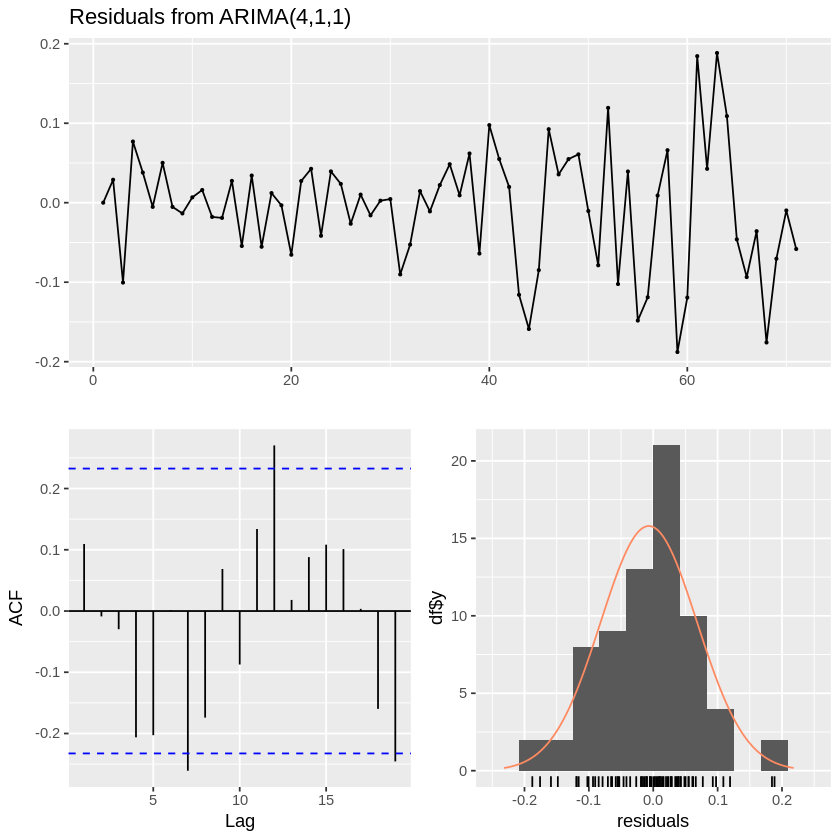

In [ ]:
# Diagnostic checks
checkresiduals(arima_model_411)

In [ ]:
residuals_411 <- residuals(arima_model_411)
#Check for normality
shapiro.test(residuals_411)


	Shapiro-Wilk normality test

data:  residuals_411
W = 0.97999, p-value = 0.3163


In [ ]:
#Check for independence
RunsTest(residuals_411)


	Runs Test for Randomness

data:  residuals_411
z = 0.47992, runs = 39, m = 36, n = 35, p-value = 0.6313
alternative hypothesis: true number of runs is not equal the expected number
sample estimates:
  median(x) 
0.002544542 


##**Conclusion on ARIMA(4,1,1) Validity**
The residual analysis of the ARIMA(4,1,1) model reveals
- **Normality** : The residuals appear to exhibit normality, as indicated by visual inspection of the plot and confirmed by the Shapiro-Wilk test, indicating that the residuals exhibit characteristics of normality.
- **Independence** :  Similarly, the runs test for randomness yields a non-significant p-value of 0.6313, which implies that they exhibit randomness

Based on these results, the ARIMA(4,1,1) model demonstrates satisfactory performance in capturing the underlying patterns and dynamics of the time series data. Both normality and randomness assumptions appear to hold for the residuals, supporting the ***validity*** of the model for forecasting purposes.

#**ARIMA(4,1,2)**:

In [ ]:
arima_model_412 = Arima(train_ts_diff$diff, order = c(4,1,2))

summary(arima_model_412)

Series: train_ts_diff$diff 
ARIMA(4,1,2) 

Coefficients:
          ar1      ar2      ar3     ar4      ma1      ma2
      -0.3422  -0.3943  -0.3580  0.5113  -0.7307  -0.2693
s.e.   0.1673   0.1286   0.1445  0.1363   0.2649   0.1854

sigma^2 = 0.005964:  log likelihood = 78.57
AIC=-143.14   AICc=-141.34   BIC=-127.4

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.007142261 0.07332085 0.05477917 56.39091 90.43969 0.3221989
                     ACF1
Training set -0.002866979


	Ljung-Box test

data:  Residuals from ARIMA(4,1,2)
Q* = 16.526, df = 4, p-value = 0.002389

Model df: 6.   Total lags used: 10



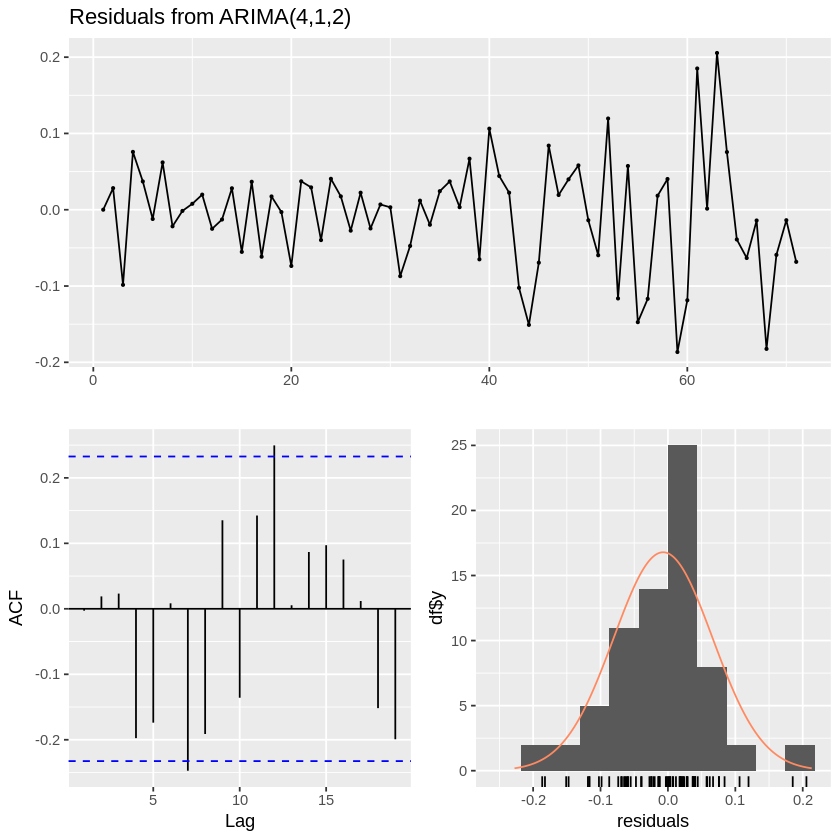

In [ ]:
# Diagnostic checks
checkresiduals(arima_model_412)

In [ ]:
residuals_412 <- residuals(arima_model_412)
#Check for normality
shapiro.test(residuals_412)


	Shapiro-Wilk normality test

data:  residuals_412
W = 0.97319, p-value = 0.1324


In [ ]:
#Check for independence
RunsTest(residuals_412)


	Runs Test for Randomness

data:  residuals_412
z = 0.95816, runs = 41, m = 36, n = 35, p-value = 0.338
alternative hypothesis: true number of runs is not equal the expected number
sample estimates:
  median(x) 
0.001426584 


##**Conclusion on ARIMA(4,1,2) Validity**
The residual analysis of the ARIMA(4,1,2) model reveals
- **Normality** : The residuals appear to exhibit normality, as indicated by visual inspection of the plot and confirmed by the Shapiro-Wilk test, indicating that the residuals exhibit characteristics of normality.
- **Independence** :  Similarly, the runs test for randomness yields a non-significant p-value of 0.338, which implies that they exhibit randomness


Similarily to ARIMA(4,1,1) , the ARIMA(4,1,2) model demonstrates satisfactory performance in capturing the underlying patterns and dynamics of the time series data. Both normality and randomness assumptions appear to hold for the residuals, supporting the ***validity*** of the model for forecasting purposes.

#**Using auto.arima()**:

In [ ]:
auto_model <- auto.arima(train_ts_diff$diff,seasonal = TRUE)
# Print the chosen model
print(auto_model)

Series: train_ts_diff$diff 
ARIMA(5,0,1) with zero mean 

Coefficients:
         ar1      ar2      ar3     ar4      ar5      ma1
      0.5878  -0.3013  -0.1487  0.6525  -0.6644  -0.7371
s.e.  0.1124   0.0824   0.0943  0.0877   0.0931   0.1042

sigma^2 = 0.005125:  log likelihood = 86.94
AIC=-159.89   AICc=-158.11   BIC=-144.05


In [ ]:
# Diagnostic checks
residuals_auto <- residuals(auto_model)
shapiro.test(residuals_auto)
RunsTest(residuals_auto)


	Shapiro-Wilk normality test

data:  residuals_auto
W = 0.96595, p-value = 0.05095



	Runs Test for Randomness

data:  residuals_auto
z = 1.6755, runs = 44, m = 36, n = 35, p-value = 0.09383
alternative hypothesis: true number of runs is not equal the expected number
sample estimates:
 median(x) 
0.00857644 


#**Conclusion on the auto selected ARIMA(5,1,1) Model:**

the auto.arima() function suggested a ARIMA(5,1,1) model , The residual analysis reveals:
- **Normality** : The residuals appear to exhibit normality, as indicated by visual inspection of the plot and confirmed by the Shapiro-Wilk test, indicating that the residuals exhibit characteristics of normality.
- **Independence** :  Similarly, the runs test for randomness yields a non-significant p-value of 0.09383, which implies that they exhibit randomness

We conclude that both normality and randomness assumptions appear to hold for the residuals, supporting the validity of the model for forecasting purposes.

---

##**From the 3 valid models , we will use BIC and choose the two best models for forecasting**

In [ ]:
BIC(arima_model_412)
BIC(arima_model_411)
BIC(auto_model)

[1] -127.4043

[1] -129.3326

[1] -144.0465

###Our goal is to minimaze the BIC so we choose : ARIMA(4,1,1) and ARIMA(5,1,1)

#**Forecasting**
Given the small set of candidate models for forecasting, we have decided to explore both the ARIMA(4,1,1) and ARIMA(5,1,1) models . By considering multiple models, we aim to compare their performance and select the one that provides the most accurate and reliable forecasts for the time series data. .

##**Forecaste Using ARIMA(4,1,1)** :

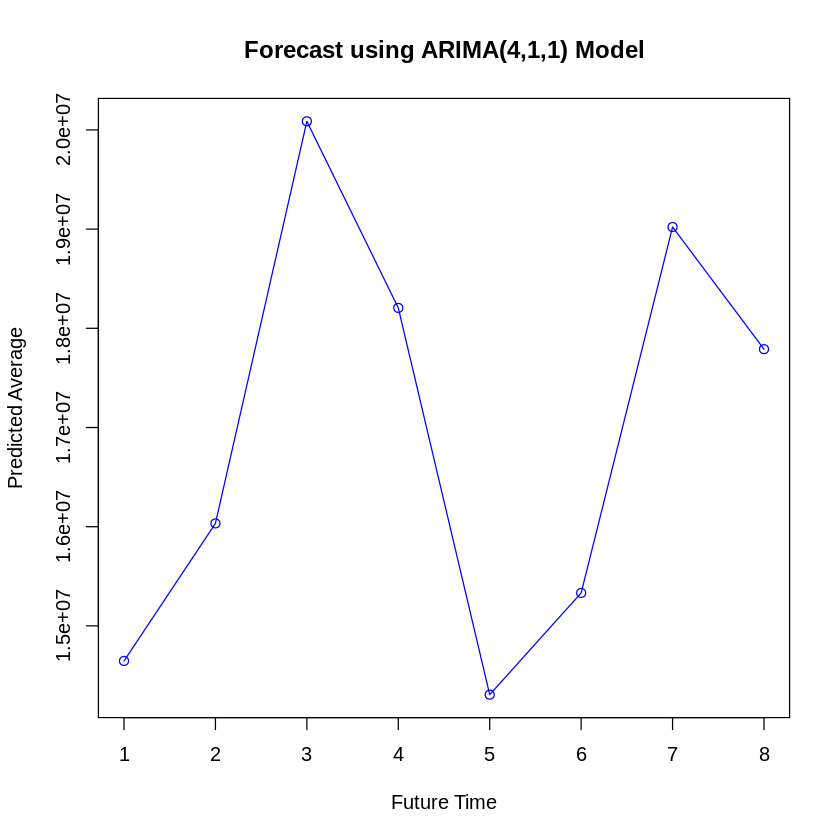

In [ ]:
horizon <- 8

arima_forecast_411 <- forecast(arima_model_411, h = horizon)

# Extract the predicted differenced log values
forecast_diff_411 <- arima_forecast_411$mean

# Reverse the differencing by adding the last actual log-transformed value
last_log_value <- tail(train_ts$log, 1)
forecast_original_scale_411 <- cumsum(c(last_log_value, forecast_diff_411))[-1]

# Reverse the log transformation to get final forecast
forecast_final_411 <- exp(forecast_original_scale_411)


# Plot the forecast
plot(forecast_final_411, type = "o", col = "blue", xlab = "Future Time", ylab = "Predicted Average", main = "Forecast using ARIMA(4,1,1) Model")


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


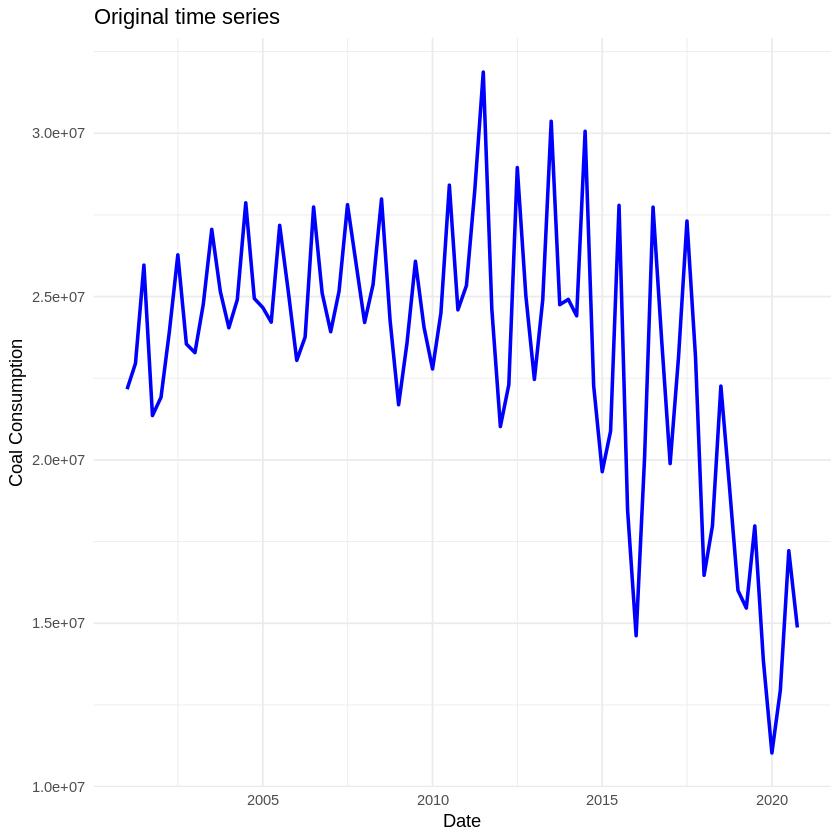

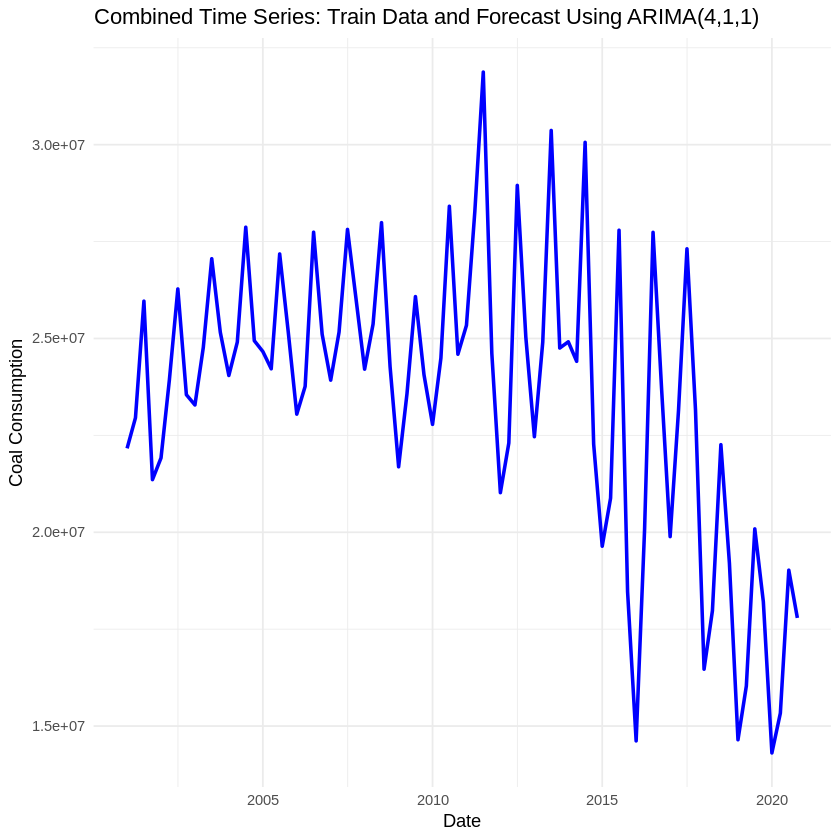

In [ ]:
comb <- c(train_ts$coal_consumption, forecast_final_411)
comb_ts <- ts(comb, start = c(2001, 1), frequency = 4)

# Convert the time series to a data frame with dates
dates <- as.Date(as.yearqtr(time(comb_ts), format = "%Y Q%q"))
df_combined <- data.frame(date = dates, coal_consumption = as.numeric(comb_ts))
par(mfrow = c(1, 2))
ggplot(coal_ts, aes(x = date, y = coal_consumption)) +
  geom_line(color = "blue",size=1) +
  labs(title = "Original time series", x = "Date", y = "Coal Consumption") +
  theme_minimal()
# Plot using ggplot
ggplot(df_combined, aes(x = date, y = coal_consumption)) +
  geom_line(color = "blue", size = 1) +
  labs(title = "Combined Time Series: Train Data and Forecast Using ARIMA(4,1,1)",
       x = "Date",
       y = "Coal Consumption") +
  theme_minimal()


In [ ]:
accuracy_metrics <- accuracy(forecast_final_411, test_ts$coal_consumption)
print(accuracy_metrics)

               ME    RMSE     MAE       MPE     MAPE
Test set -2005181 2589010 2344172 -14.55384 16.67223


##**Forecaste Using ARIMA(5,1,1) suggested by auto.arima()** :

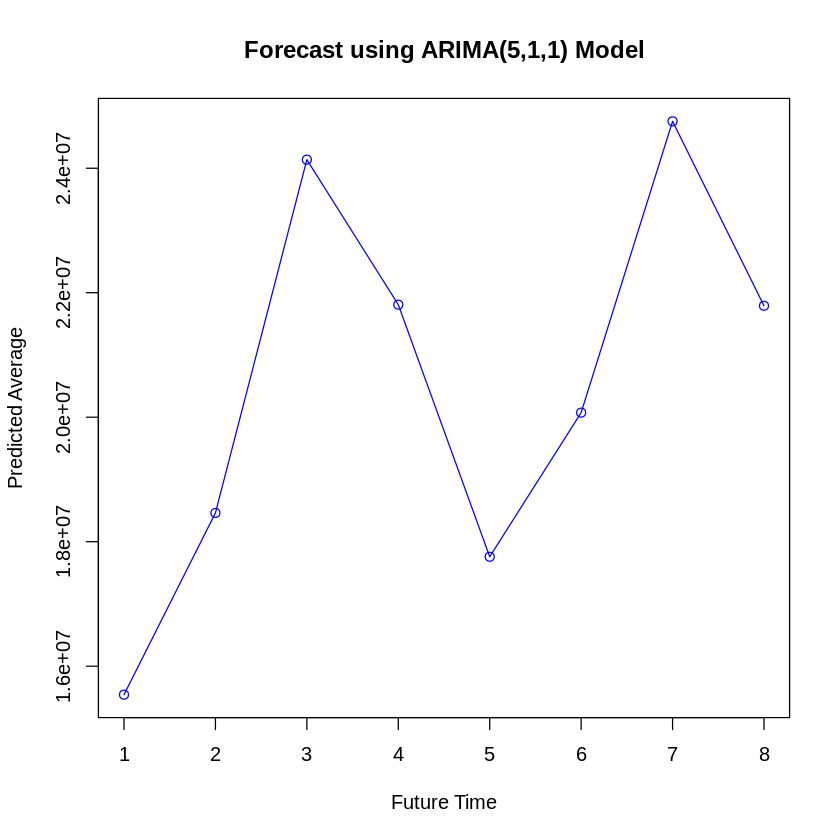

In [ ]:
horizon <- 8

arima_forecast_511 <- forecast(auto_model, h = horizon)

# Extract the predicted differenced log values
forecast_diff_511 <- arima_forecast_511$mean

# Reverse the differencing by adding the last actual log-transformed value
last_log_value <- tail(train_ts$log, 1)
forecast_original_scale_511 <- cumsum(c(last_log_value, forecast_diff_511))[-1]

# Reverse the log transformation to get final forecast
forecast_final_511 <- exp(forecast_original_scale_511)


# Plot the forecast
plot(forecast_final_511, type = "o", col = "blue", xlab = "Future Time", ylab = "Predicted Average", main = "Forecast using ARIMA(5,1,1) Model")


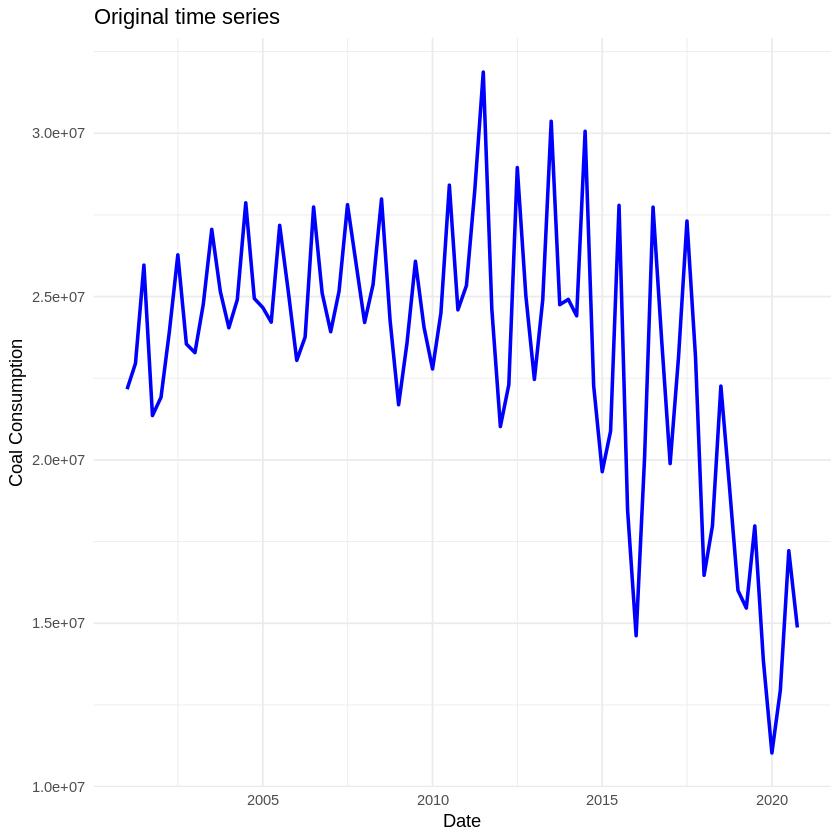

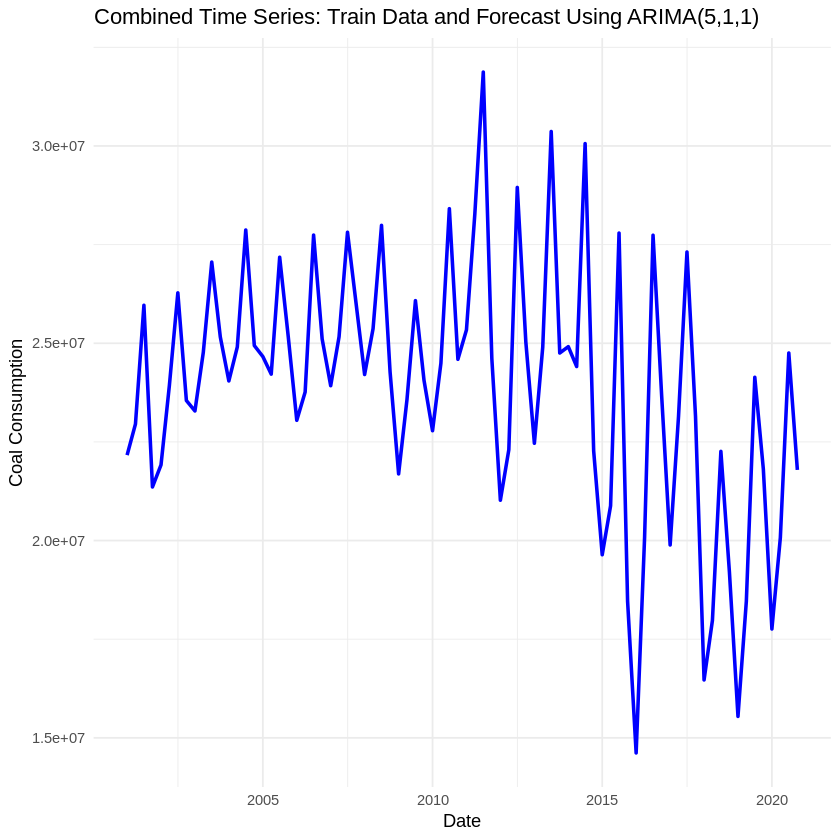

In [ ]:
comb <- c(train_ts$coal_consumption, forecast_final_511)
comb_ts <- ts(comb, start = c(2001, 1), frequency = 4)

# Convert the time series to a data frame with dates
dates <- as.Date(as.yearqtr(time(comb_ts), format = "%Y Q%q"))
df_combined <- data.frame(date = dates, coal_consumption = as.numeric(comb_ts))
par(mfrow = c(1, 2))
ggplot(coal_ts, aes(x = date, y = coal_consumption)) +
  geom_line(color = "blue",size=1) +
  labs(title = "Original time series", x = "Date", y = "Coal Consumption") +
  theme_minimal()
# Plot using ggplot
ggplot(df_combined, aes(x = date, y = coal_consumption)) +
  geom_line(color = "blue", size = 1) +
  labs(title = "Combined Time Series: Train Data and Forecast Using ARIMA(5,1,1)",
       x = "Date",
       y = "Coal Consumption") +
  theme_minimal()


In [ ]:
accuracy_metrics <- accuracy(forecast_final_511, test_ts$coal_consumption)
print(accuracy_metrics)

               ME    RMSE     MAE       MPE     MAPE
Test set -5618217 6233751 5733124 -39.29394 40.01201


#**Comparison of ARIMA Candidates Models**
##Interpretation of Metrics:
- **Bias (ME, MPE)**:

**ARIMA(4,1,1)** has a smaller magnitude of mean error (-2,005,181 vs. -5,618,217) and lower percentage error (-14.55% vs. -39.29%), indicating that its forecasts are closer to actual values, with less consistent underprediction.

 - **Error Magnitude (RMSE, MAE, MAPE)**:

**ARIMA(4,1,1**) exhibits lower RMSE, MAE, and MAPE values, meaning that on average, its predictions deviate less from the observed values than **ARIMA(5,1,1).**

**Conclusion:**

The **ARIMA(4,1,1)** model outperforms **ARIMA(5,1,1)** based on the following:

Lower forecast errors: Smaller RMSE and MAE indicate more accurate point forecasts.

Lower bias: The mean errors (ME and MPE) are less extreme, suggesting that the ARIMA(4,1,1) model's predictions are closer to actual values.

Better percentage error: A MAPE of 16.67% (vs. 40.01%) shows that on average, the forecast error is significantly lower in relative terms.

---
#**Selected ARIMA Model for Future Predictions**
After this analysis, we have selected the **ARIMA(4,1,1)** model as the chosen model for future predictions.

---

#**Conclusion**
Upon analyzing the summaries and error measures for the ARIMA models used in this project, it is evident that the ARIMA(4,1,1) model generally provides a better fit to the data and offers improved forecasting accuracy compared to the ARIMA(5,1,1) model.

However, while this analysis indicates that the ARIMA(4,1,1) model yields lower forecast errors and reduced bias, it is important to note that this does not necessarily imply it is the optimal model for every scenario. Based on the results obtained, we can conclude that the ARIMA(4,1,1) model fits the data well and demonstrates promising forecasting capabilities for coal consumption.

---